# Spring 2024 6.8200 Computational Sensorimotor Learning Assignment 8

In this assignment, we will implement Deep Q Network algorithm.

You will need to <font color='blue'>answer the bolded questions</font> and <font color='blue'>fill in the missing code snippets (marked by **TODO**)</font>.

There are (approximately) **145 total points** to be had in this PSET and **10 bonus points**.  `ctrl-f` for "pts" to ensure you don't miss questions.

For this assignment, you might find GPU machines to be helpful. You can enable GPUs by:

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

<font color='red'> Make sure you set `show_progress=False` in `dqn_sweep` when you are ready to submit the homework to remove unneccessary outputs.

# Setup

In [1]:
!pip install gym-minigrid > /dev/null 2>&1

In [2]:
%matplotlib inline
import pickle
import numpy as np
import random
import gym
import torch
import seaborn as sns
import gym_minigrid
from tqdm.notebook import tqdm
from dataclasses import dataclass

from torch import nn
import pandas as pd
from torch import optim
from typing import Any
from copy import deepcopy
from collections import deque
from gym_minigrid.wrappers import ObservationWrapper
from gym_minigrid.envs.doorkey import DoorKeyEnv

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [3]:
from google.colab import drive

drive.mount('/content/drive/')

PATH = "/content/drive/MyDrive/Colab Notebooks"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]

In [5]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
stolen from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)


class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1


# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://github.com/maximecb/gym-minigrid). This environment is a $5\times 5$ gridworld that we previously used in the policy gradients assignment. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.

The environment is visually shown below:

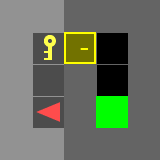


In [7]:
env = DoorKeyEnv5x5()

As a refresher, `env.reset()` returns an observation variable, which is a dictionary that contains the current view of the environment (as an image)., agent's facing direction (0: right, 1: down, 2: left, 3: up), and a mission description as a string. The current view of the environment has a similar format as a normal 3-channel image (shape: $7\times7\times3$), but it is not an actual image. The values are not pixels. Each value represents a state of the object on that location. Checkout [the source code](https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/minigrid.py) for more details. The action space is $7$-dimensional: 0: turn left, 1: turn right, 2: forward, 3: pickup an object, 4: drop an object, 5: activate an object, 6: done completing task.

# Deep Q Network
In the last assignment, we used tabular Q learning for learning to solve FrozenLake. The tabular approach requires a table to store the $Q$ values for all the possible states and actions pairs. This is only feasible when the state space is discrete and low-dimensional. However, in many more practical domains, the state space is high-dimensional, such as images. For example, in video game environments, each frame can be a state. Even a small change in the pixel value (the agent moves by a little bit) will result in a new state. In such scenarios, it becomes impractical to create a $Q$ table for such a big state space as it would require a huge amount of RAM. To overcome this issue, we will make use of function approximators (e.g., neural networks) to approximate the $Q$ table. This leads to the development of an algorithm called _Deep $Q$ Network (DQN)_. Let's implement this. Feel free to refer to the original [DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) paper.

## Define the Network architecture

**Q1.1 (10 pts)**: Fill in the missing code for `DQNetwork`.

In [9]:
class DQNetwork(nn.Module):
    def __init__(self, action_dim):
        """
        Initializes the DQNetwork with a convolutional neural network architecture.

        Parameters:
        - action_dim (int): The number of possible actions, determining the output size of the network.
        """
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU()
        )
        self.fcs = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, ob):
        """
        Processes an observation through the network to predict Q values for each action.

        Parameters:
        - ob (torch.Tensor): The input observation image of shape [batch_size, height, width, channels].

        Returns:
        - torch.Tensor: The predicted Q values for each action, of shape [batch_size, action_dim].
        """
        #### TODO (5pts): get the Q values for each action given the input
        #### the input shape is: [batch_size, H, W, 3]
        #### output shape should be: [batch_size, # of actions]

        input = ob.transpose(1, 3).transpose(2, 3)

        out = self.conv_net(input)
        out = out.view(out.size(0), -1)
        out = self.fcs(out)

        return out


**Q1.2 (5 pts)**: What does each argument in `nn.Conv2d(3, 16, (3, 3))` mean?

**A**: Conv2d means the 2D convolutional network. The first 3 means the size of the input channel. The second 16 means the number of output of this convolutional network. This also implies that 16 convolutional filters are applied to the input. The last (3,3) means that this network's convolutional filter has the shape of height 3 and width 3.

## Build a replay buffer

Here we implement a specific kind of replay buffer called a [Cyclic Buffer](https://en.wikipedia.org/wiki/Circular_buffer)

**Q2.1 (20 pts)**: Fill in the missing code for `CyclicBuffer`.

In [10]:
# create a replay buffer
class CyclicBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.cur_pos = 0

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, item):
        return self.buffer[item]

    def append(self, data):

        """
        Adds a new piece of data to the buffer.

        Parameters:
        - data: The data to be added to the buffer.
        """
        #### TODO (10pts): add data to the buffer
        #### if the buffer is not full yet, you can simply append the data to the buffer
        #### otherwise, you need to replace the oldest data with the current data (FIFO)
        #### Hint: you may find self.cur_pos useful, it can be used as a position index
        #### to keep track of where to add data
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
        else:
            self.buffer[self.cur_pos] = data
            self.cur_pos = (self.cur_pos + 1) % self.capacity


    def sample(self, batch_size):
        """
        Randomly selects a batch of data from the buffer. The size of the batch is the minimum of the requested
        batch size and the current size of the buffer. If the requested batch size equals the buffer size, all
        data in the buffer is returned.

        Parameters:
        - batch_size (int): The size of the batch to sample.

        Returns:
        - list: A list containing the sampled batch of data.
        """
        #### TODO (10pts): sample a batch from the buffer
        batch = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        return batch


    def get_all(self):
        """
        Retrieves all data stored in the buffer.

        Returns:
        - list: A deepcopy of all data currently stored in the buffer.
        """
        return deepcopy(self.buffer)

    def clear(self):
        """
        Removes all data from the buffer, effectively resetting its state.
        """
        self.buffer.clear()
        self.cur_pos = 0


In [11]:
def check_cyclic_buffer():
  # Check your cyclic buffer implementation.
  # DO NOT MODIFY
  buffer = CyclicBuffer(capacity=5)

  buffer.append(1)
  buffer.append(2)
  buffer.append(3)

  assert len(buffer) == 3, f'Expected buffer size 3, got buffer size: {len(buffer)}'

  buffer.append(4)
  buffer.append(5)
  buffer.append(6)
  buffer.append(7)
  assert buffer.cur_pos == 2, f'Expected buffer.cur_pos == 2, got cur_pos: {buffer.cur_pos}'
  assert len(buffer) == 5, f'Expected a full buffer with size 5, got buffer size: {len(buffer)}'

  assert buffer.buffer == [6,7,3,4,5], f'Incorrect buffer structure. Expected [6,7,3,4,5], got: {buffer.buffer}'

  data = buffer.sample(2)

  assert len(data) == 2, f"Expected sample size of 2, got sample size: {len(data)}"
  assert data[0] != data[1], "Make sure buffer samples unique elements. Do not allow duplicate samples in batch."
  assert buffer.buffer == [6,7,3,4,5], f"Buffer changed after sampling. Make sure sampling doesn't modify the buffer."

  print("Buffer implementation passed.")

check_cyclic_buffer()

Buffer implementation passed.


## Create a DQN agent

Note: In the original DQN paper, the authors proposed to use a hard update on the target $Q$ network every $K$ steps. Later on, people find that using polyak averaging to soft update the target $Q$ network leads to more stable training. We will implement both these ideas in `DQNAgent`.  

In the experiments in the following sections, we will use the soft update scheme to update our target $Q$ network. The soft update has the following formula (Section 9.2.4 Lecture Notes. Slide 43 DQL slides):
$$\theta_{Q_{tgt}} = \tau\theta_Q+(1-\tau)\theta_{Q_{tgt}} $$

where $\tau$ is typically set to be very close to $0$.

**Q3.1 (40 pts)**: Fill in the missing code in `DQNAgent` (you don't need to write the code for double DQN yet).

In [16]:
@dataclass
class DQNAgent:
    env: gym.Env
    learning_rate: float
    gamma: float
    memory_size: int # We use memory/buffer interchangeably
    initial_epsilon: float
    min_epsilon: float
    max_epsilon_decay_steps: int
    warmup_steps: int
    batch_size: int
    target_update_freq: int
    enable_double_q: bool = False
    disable_target_net: bool = False
    device: str = None
    tau: float = 0.005

    def __post_init__(self):
        self.reset()

    def reset(self):
        """
        Resets the agent to its initial state.
        """
        if self.device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #### TODO: create a Deep Q network Agent.
        #### For our purposes include the following:
        #### -a replay buffer with capacity=self.memory_size. Memory = Buffer
        #### -an Adam optimizer with lr=self.learning_rate,
        #### -SmoothL1 loss instance,
        ####  -a deep Q network
        ####  -A deep Q TARGET network (Make sure to set to eval mode)
        #### -Make sure the networks are on the correct device!!! use [tensor].to(self.device)

        ## Deep Q network
        self.qnet = DQNetwork(self.env.action_space.n).to(self.device)

        self.qnet_target = DQNetwork(self.env.action_space.n).to(self.device).eval()
        self.qnet_target.load_state_dict(self.qnet.state_dict())

        ## replay buffer
        self.memory = CyclicBuffer(self.memory_size)

        ## optimizer
        self.optim = torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)

        ## smoothL1 loss instance
        self.loss_fn = nn.SmoothL1Loss()


        ####
        self.epsilon = self.initial_epsilon
        self.ep_reduction = (self.epsilon - self.min_epsilon) / float(self.max_epsilon_decay_steps)
        if self.disable_target_net:
            #### TODO: set the target_update_freq to be proper value so that the target Q network will always be same as the Q network
            #### You don't need to fill in this value until Q4.3
            self.target_update_freq = 1


    @torch.no_grad()
    def get_action(self, ob, greedy_only=False):
        """
        Selects an action based on the current state observation using an epsilon-greedy policy.

        Parameters:
        - ob (numpy.ndarray): The current state observation.
        - greedy_only (bool): If True, the method always selects the action with the highest Q value. If False, it
        selects a random action with probability epsilon.

        Returns:
        - int: The selected action.
        """
        ob = ob[np.newaxis, :]
        ob = torch.from_numpy(ob).float().to(self.device)
        q_val = self.qnet(ob)
        action = self.epsilon_greedy_policy(q_val, greedy_only=greedy_only)

        return action

    def epsilon_greedy_policy(self, q_values, greedy_only=False):
        """
        Implements an epsilon-greedy policy for action selection.

        Parameters:
        - q_values (torch.Tensor): The Q values for all actions in the current state.
        - greedy_only (bool): If True, ignores epsilon and selects the action with the highest Q value.

        Returns:
        - int: The index of the selected action.
        """
        #### TODO: epsilon greedy exploration
        #### we have an extra flag `greedy_only` here,
        #### if greedy_only is True, then we need to return the action that
        #### has the maximum Q values.
        #### if greedy_only is False, we do epsilon greedy.

        if greedy_only:
            return torch.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                return np.random.choice(7)

            else:
                return torch.argmax(q_values).item()


    def add_to_memory(self, ob, next_ob, action, reward, done):
        """
        Adds an experience tuple to the replay buffer.

        Parameters:
        - ob: The current state observation.
        - next_ob: The next state observation after taking the action.
        - action: The action taken in the current state.
        - reward: The reward received after taking the action.
        - done: A boolean indicating whether the episode has ended.
        """
        #### TODO: add data to the replay buffer. Avoid np.arrays.
        #### you need to make sure the variables are in the right tensor shape.

        ob = torch.from_numpy(np.array([ob])).float()
        next_ob = torch.from_numpy(np.array([next_ob])).float()
        action = torch.tensor([action]).long()
        reward = torch.tensor([reward]).float()
        done = torch.tensor([done]).float()

        self.memory.append((ob, next_ob, action, reward, done))



    def update_Q(self):
        """
        Performs a single update step of the Q-network based on a batch of experiences from the replay buffer.

        Returns:
        - float: The loss value of the update step.
        """
        # we only start updating the Q network if there are enough samples in the replay buffer
        if len(self.memory) < self.warmup_steps:
            return 0

        #### TODO: sample data from the replay buffer, and put them on the correct device (use [tensor].to(self.device))
        #### you need to make sure the variables are in the right tensor shape.

        sampled_batch = self.memory.sample(self.batch_size)

        batch_states = torch.cat([transition[0] for transition in sampled_batch]).to(self.device)
        batch_next_states = torch.cat([transition[1] for transition in sampled_batch]).to(self.device)

        batch_actions = torch.cat([transition[2] for transition in sampled_batch]).unsqueeze(1).to(self.device)
        batch_rewards = torch.cat([transition[3] for transition in sampled_batch]).unsqueeze(1).to(self.device)
        batch_dones = torch.cat([transition[4] for transition in sampled_batch]).unsqueeze(1).to(self.device)



        #### TODO: update Q function with Bellman backup. Torch.gather() may prove useful for this section
        ##### get Q(s_t, a_t)

        q_out = self.qnet(batch_states)   ## shape = [batch_len, state_space]
        q_a = q_out.gather(1, batch_actions)  ## shape = [batch_len, 1]

        ##### get maxQ(s_{t+1}, a_{t+1})
        ##### you will need to implement both DQN and double DQN here
        ##### i.e., you need to check `if self.enable_double_q`
        ##### remember to not propogate gradient when working with target

        max_q_next = self.qnet_target(batch_next_states).max(1)[0].unsqueeze(1).detach() ## torch.max retruns (value, index), shape = [batch_len, 1]

        if self.enable_double_q:
            next_action_idx = self.qnet_target(batch_next_states).max(1)[1].unsqueeze(1).long()
            max_q_next = (self.qnet_target(batch_next_states).detach()).gather(1, next_action_idx)


        ##### get the target Q value from the bellman equation
        target_q_values = batch_rewards + (1 - batch_dones) * self.gamma * max_q_next


        ##### update the Q network
        self.optim.zero_grad()
        #TODO
        loss = self.loss_fn(target_q_values, q_a)
        loss.backward()
        self.optim.step()

        return loss.item()

    def decay_epsilon(self):
        """
        Reduces epsilon linearly over time until it reaches min_epsilon, ensuring that the exploration rate decreases
        as the agent learns more about the environment.
        """
        #### TODO: linearly decay epsilon
        #### reduce epsilon value by ep_reduction every time the function is called,
        #### make sure epsilon is not smaller than self.min_epsilon

        self.epsilon = max(self.epsilon - self.ep_reduction, self.min_epsilon)



    def update_target_qnet(self, step, soft=True):
        """
        Updates the target Q-network.

        Parameters:
        - step (int): The current step number, used to determine when to perform hard updates.
        - soft (bool): If True, performs a soft update; otherwise, performs a hard update.
        """
        if not soft:
            if step % self.target_update_freq == 0:
                #### TODO: update the target Q function in a "hard" way
                #### copy the parameter values in self.qnet into self.target_qnet
                ### use .copy_() to avoid pointer issues

                for target_param, qnet_param in zip(self.qnet_target.parameters(), self.qnet.parameters()):
                    target_param.data.copy_(qnet_param.data)
        else:
            #### TODO: soft update on taget Q network.
            #### similar to polyak averaging, we update the target Q network slowly
            #### $\theta_Qtgt = \tau*\theta_Q + (1-\tau)*\theta_Qtgt
            ###  use .copy_() to avoid pointer issues
            for target_param, qnet_param in zip(self.qnet_target.parameters(), self.qnet.parameters()):
                target_param.data.copy_((self.tau) * qnet_param.data + (1.0-self.tau) * target_param.data)


**Q3.2 (5 pts)**: What is Smooth L1 Loss? And what's the advantage of using this type of loss compared to MSE loss in updating the $Q$ function?

**A**: smooth L1 loss is defined as 0.5x(a-b)^2 if |a-b| < threshold and |a-b|-0.5 x threshold otherwise. Note that it is defined element-wise. Smooth L1 Loss is advantageous over MSE because it is less sensitive to outliers

## Utils for running experiment

In [13]:
# you don't need to modify the following code.
@dataclass
class DQNEngine:
    env: gym.Env
    agent: Any
    max_steps: int
    show_progress: bool = False
    show_video: bool = False

    def test(self, env=None, render=False):
        """
        Evaluates the agent's performance in the given environment.

        Parameters:
        - env (gym.Env, optional): The environment to test the agent in. If None, uses the engine's environment.
        - render (bool): Whether to render the environment at each step.

        Returns:
        - float: The total reward accumulated over the episode.
        """
        env = self.env if env is None else env
        ob = env.reset()
        ret = 0
        for i in range(100):
            if render:
                env.render()
            action = self.agent.get_action(ob, greedy_only=True)
            next_ob, reward, done, truncated, info = env.step(action)
            ret += reward
            ob = next_ob
            if done:
                break
        return ret

    def run(self, n_runs=1):
        """
        Executes multiple runs of the agent in the environment, training the agent in each run.

        Parameters:
        - n_runs (int): The number of separate runs to execute.

        Returns:
        - list: A list of pandas DataFrame logs for each run, containing columns for the cumulative reward ('return'),
                the step count ('steps'), the episode number ('episode'), and the initial epsilon value ('epsilon').
        """
        rewards = []
        log = []

        for i in tqdm(range(n_runs), desc='Runs'):
            ep_rewards = []
            ep_steps = []
            self.agent.reset()
            # we plot the smoothed return values
            smooth_ep_return = deque(maxlen=10)
            ob = self.env.reset()
            print('reset_ob_shape=', np.shape(ob))
            ret = 0
            num_ep = 0
            for t in tqdm(range(self.max_steps), desc='Step'):
                if len(self.agent.memory) < self.agent.warmup_steps:
                    action = self.env.action_space.sample()
                else:
                    action = self.agent.get_action(ob)
                next_ob, reward, done, truncated, info = self.env.step(action)

                true_done = done and not info.get('TimeLimit.truncated', False)
                self.agent.add_to_memory(ob, next_ob, action, reward, true_done)

                self.agent.update_Q()
                ret += reward
                ob = next_ob
                if done or truncated:
                    ob = self.env.reset()
                    smooth_ep_return.append(ret)
                    ep_rewards.append(np.mean(smooth_ep_return))
                    ep_steps.append(t)
                    ret = 0
                    num_ep += 1
                    if self.show_progress:
                        print(f'Step:{t}  epsilon:{self.agent.epsilon}  '
                            f'Smoothed Training Return:{np.mean(smooth_ep_return)}')
                    if num_ep % 10 == 0:
                        test_ret = self.test()
                        if self.show_progress:
                            print('==========================')
                            print(f'Step:{t} Testing Return: {test_ret}')
                self.agent.decay_epsilon()
                self.agent.update_target_qnet(t, soft=not self.agent.disable_target_net)

            rewards.append(ep_rewards)
            run_log = pd.DataFrame({'return': ep_rewards,
                                    'steps': ep_steps,
                                    'episode': np.arange(len(ep_rewards)),
                                    'epsilon': self.agent.initial_epsilon})
            log.append(run_log)
        return log



def dqn_sweep(agents, labels, n_runs=1, max_steps=100000, show_progress=False):
    """
    Performs a sweep over different DQN agents to compare their performance.
    This function takes a list of DQN agents and their labels, then runs each agent for a specified number of runs and
    steps, tracking their performance. Useful for comparing the effects of different hyperparameters or architectures
    across multiple agents.

    Parameters:
    - agents (list): A list of DQNAgent instances to be evaluated.
    - labels (list): A list of strings representing labels for each agent, used in the logs to identify the agents.
    - n_runs (int): The number of runs to execute for each agent.
    - max_steps (int): The maximum number of steps to execute in each run.
    - show_progress (bool): Whether to display progress bars during execution.

    Returns:
    - pandas.DataFrame: A concatenated DataFrame containing the logs of all runs for all agents, with an additional
                         'Agent' column indicating the label of the agent for each log entry.
    """
    logs = dict()
    for idx, agent in enumerate(tqdm(agents)):
        engine = DQNEngine(env=agent.env, agent=agent,
                           max_steps=max_steps, show_progress=show_progress)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['Agent'] = labels[idx]
        logs[f'{idx}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs


## Run experiments

We have provided for you default hyperparameters to use in `get_default_config` to train your DQN agent. Within 100,000 steps your vanilla DQN should be getting reasonable performance and solving the task (smoothed return for the last 10,000 consecutive episodes is above 0.8). If this isn't the case your implementation is most likely incorrect. Use the same set of hyperparameters throughout the assignment unless we tell you to modify the config.

You can use `show_progress = True` while testing your code for a faster feedback cycle.

In [14]:

def get_default_config():
    env = DoorKeyEnv5x5()
    env = ImgObsWrapper(env)
    set_random_seed(0)
    config = dict(
        env=env,
        learning_rate=0.00025,
        gamma=0.99,
        memory_size=200000,
        initial_epsilon=1.0,
        min_epsilon=0.1,
        max_epsilon_decay_steps=150000,
        warmup_steps=500,
        target_update_freq=2000,
        batch_size=32,
        device=None,
        disable_target_net=False,
        enable_double_q=False
    )
    return config

**Q4.1 (5 pts)**: Train your DQN agent and plot its return curve. We have provided you with a `plot` function where the `x_keys` should be `steps`, and `y_keys` should be `return`. Note that `return` corresponds to the return from an episode and that our environment only provides a reward of 1 when the goal is reached.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

reset_ob_shape= (7, 7, 3)


Step:   0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-6-0fd3dd2791b9>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)


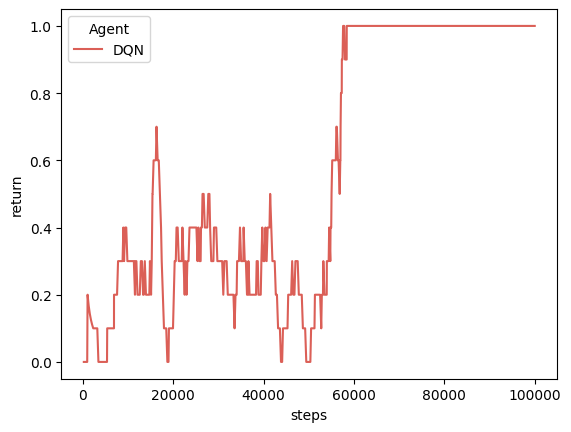

In [17]:
# It takes 20 minutes in T4.
import pickle
config = get_default_config()
agent = DQNAgent(**config)

#TODO
dqn_logs = dqn_sweep([agent], ["DQN"], n_runs=1, max_steps=100000, show_progress=False)

with open(f'{PATH}/dqn_logs.pkl', 'wb') as f:
  pickle.dump(dqn_logs, f)


#### Plot of the return curves
plot(dqn_logs, x_key='steps', y_key='return', legend_key='Agent', estimator='mean', ci=None)


Do we really need a target network? Let's see what if we don't use a target network.

**Q4.2 (10 pts)**: Fill in the missing code in `reset` in `DQNAgent` for the case where we don't use a target Q network (i.e., when `disable_target_net = True`). Plot the return curve for this agent.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

reset_ob_shape= (7, 7, 3)


Step:   0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-6-0fd3dd2791b9>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)


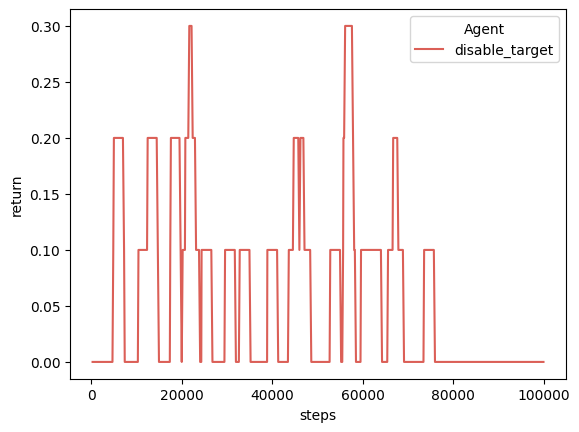

In [22]:
# It takes 20 minutes in T4.

config = get_default_config()
### TODO: Modify config
config["disable_target_net"] = True

agent = DQNAgent(**config)

no_tgt_logs = dqn_sweep([agent], ["disable_target"], n_runs=1, max_steps=100000, show_progress=False)

with open(f'{PATH}/no_tgt_logs.pkl', 'wb') as f:
  pickle.dump(no_tgt_logs, f)

#### plot the return curves
plot(no_tgt_logs, x_key='steps', y_key='return', legend_key='Agent', estimator='mean', ci=None)

Do we really need a replay buffer? Let's see what happens if we do not use a replay buffer. Since we are doing batch update on `Q` function, we can try using a very small replay buffer instead. We can make the size of the replay buffer same as the batch size.

We provide the output of a DQN with a small buffer and store it in the variable 'small_buffer_logs'. Run the below cell for later use.

**Q4.3 (10 pts)**: What differences in the results would you expect to observe between the DQN agent trained with a normal/larger buffer size (200,000 in this case) and the DQN agent trained on a small buffer size (batch_size)?

**A**:The larger replay buffer reduces the correlation between samples by randomly selecting a set of transitions to update the network from the buffer. Therefore a smaller buffer size can decrease the stability of the training, making the learning longer.

will be placed in the single file you specified.

--2024-04-21 23:34:43--  https://drive.google.com/uc?export=download&id=1wVTG5hd8e0dNmQGfsqC4JN40u1nI4eUK
Resolving drive.google.com (drive.google.com)... 142.251.180.139, 142.251.180.102, 142.251.180.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.180.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1wVTG5hd8e0dNmQGfsqC4JN40u1nI4eUK&export=download [following]
--2024-04-21 23:34:43--  https://drive.usercontent.google.com/download?id=1wVTG5hd8e0dNmQGfsqC4JN40u1nI4eUK&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.120.132, 2607:f8b0:4001:c18::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.120.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43892 (43K) [application/octet-stream]
Saving to: ‘small_buffer_logs.pkl’

smal

<ipython-input-6-0fd3dd2791b9>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)


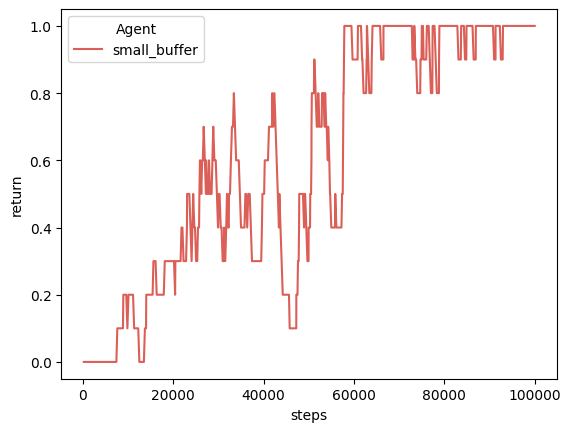

In [23]:
#### DQN with small buffer size is trained by setting the following config options.
# config = get_default_config()
# config['warmup_steps'] = config['batch_size']
# config['memory_size'] = config['batch_size']

!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1wVTG5hd8e0dNmQGfsqC4JN40u1nI4eUK' -O small_buffer_logs.pkl

with open('small_buffer_logs.pkl', 'rb') as f:
  small_buffer_logs = pickle.load(f)

plot(small_buffer_logs, x_key='steps', y_key='return', legend_key='Agent', estimator='mean', ci=None)


**Q4.4 (10 pts)**: Fill in the missing code for double DQN in `update_Q` in `DQNAgent` (when `enable_double_q=True`, your code should work for both cases). Train the double DQN agent, and plot the return curve.

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

reset_ob_shape= (7, 7, 3)


Step:   0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-6-0fd3dd2791b9>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)


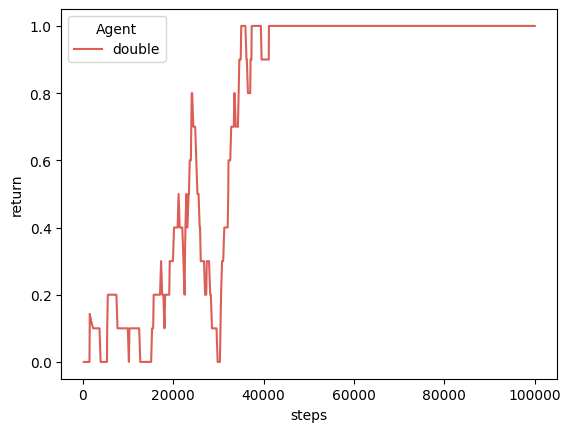

In [21]:
# It takes 20 minutes in T4.

config = get_default_config()
#TODO: Modify configs
config["enable_double_q"] = True

agent = DQNAgent(**config)

doubleq_logs = dqn_sweep([agent], ["double"], n_runs=1, max_steps=100000, show_progress=False)


with open(f'{PATH}/doubleq_logs.pkl', 'wb') as f:
  pickle.dump(doubleq_logs, f)


#### plot the return curves
plot(doubleq_logs, x_key='steps', y_key='return', legend_key='Agent', estimator='mean', ci=None)


**Q4.5 (10 pts)**: Plot all the logs (DQN, double DQN, no target network, small replay buffer) in the same figure. What are the differences in success performance between the variants?

**A**: The performance of each variant shows the following order. Double DQN > DQN > DQN with smaller buffer > no target network.

**Q4.6 (15 pts)**: Explain why each of our ablations (removing the target network, using a small buffer, and using double DQN) are more or less sucessfull than the vanilla DQN agent.

**A**:
1) Without the target network, Q-learning's target-value (TD-target in this case) also depends on the theta parameter. This means that whenever we update the parameters, it updates the target-value as well. This varying target-value degrades the stability of the training. Therefore we can address this problem by introducing a new network only for the target-value. Now because the target-value is independent of gradient descent optimizing and only changes while the target network update, it varies much lesser than vanila DQN. We can expect a much stable learning.  

2) Using smaller buffer means that we have higher possiblility to choose correlated transitions to update the network. This degrades the convergence of stochastic gradient descent optimizer.

3) Finally, double DQN decreases the DQN being degraded by the biased estimation. Using the two separate Q network estimator, double DQN can bring up the unbiased estimation. This can reduce the over-estimation problem in vanilla DQN  


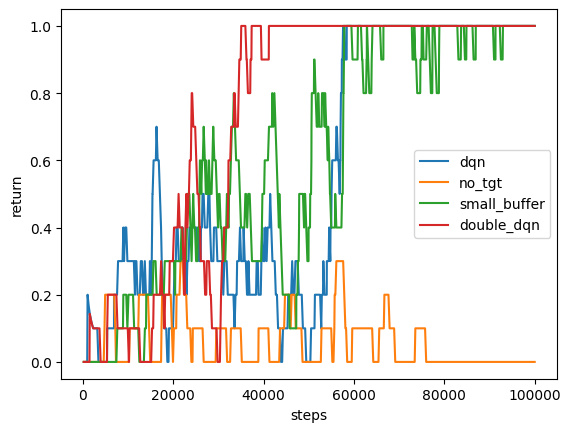

In [24]:
#### Plot of all the logs together

import matplotlib.pyplot as plt

with open(f'{PATH}/dqn_logs.pkl', 'rb') as f:
  dqn_logs = pickle.load(f)
with open(f'{PATH}/no_tgt_logs.pkl', 'rb') as f:
  no_tgt_logs = pickle.load(f)
with open('small_buffer_logs.pkl', 'rb') as f:
  small_buffer_logs = pickle.load(f)
with open(f'{PATH}/doubleq_logs.pkl', 'rb') as f:
  doubleq_logs = pickle.load(f)

plt.figure()
sns.lineplot(data=dqn_logs, x="steps", y="return", label="dqn")
sns.lineplot(data=no_tgt_logs, x="steps", y="return", label="no_tgt")
sns.lineplot(data=small_buffer_logs, x="steps", y="return", label="small_buffer")
sns.lineplot(data=doubleq_logs, x="steps", y="return", label='double_dqn')

plt.legend()
plt.show()

# Survey (bonus, 10 pts)
Please fill out [this anonymous survey](https://forms.gle/sD48uX1zR7FSrj3j9) and enter the code below to receive credit. Thanks!

**Bonus code**: final_dqn

# Submission
Run the below cell to generate an html file with your notebook. You can also follow the piazza instructions for PDF generation

In [ ]:
!jupyter nbconvert --to html '/content/drive/My Drive/path_to_notebook.ipynb'